## Генерация текста с помощью символьной RNN.


Задача: научиться генерировать текст помощью простой рекуррентной нейронной сети ( RNN).

В качестве корпуса текстов для обучения будет выступать роман в стихах "Евгений Онегин".


In [4]:
try:
    from torchinfo import summary
except:    
    !pip install torchinfo
    from torchinfo import summary

import os
import random
from collections import Counter
from tqdm import tqdm


import time

import torch

from torch.utils.data import Dataset, DataLoader
from torch import nn
from torchvision.transforms import ToTensor, Lambda
from torchvision.io import read_image
import torchvision.transforms as transforms
import torchvision.models as models

from IPython.display import clear_output 

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import ConfusionMatrixDisplay

torch.manual_seed(17)
RANDOM_STATE=50

import numpy as  np
import pickle
import matplotlib.pyplot as plt

### 1. Загрузка  и предобработка данных.

In [ ]:
FOR Kaggle!
# os.makedirs('data', exist_ok=True) 
# !cp /kaggle/input/text-rnn/onegin.txt  /kaggle/working/data/

In [7]:
# файл с текстом  находится в папке 'data' текущей директории.
name_file='onegin.txt'

In [9]:
path_text =os.path.join(os.getcwd(),'data',name_file)

with open(path_text, 'r', encoding='utf8') as file:
    text=list(file)
text = ''.join([i.replace('\t\t','').lower() for i in text]) #  избавимся от табуляции, приведем символы к нижнему регистру
print(text[:200], '\n') 
print (f' Длина текста :  {len(text)} символов')


i

«мой дядя самых честных правил,
когда не в шутку занемог,
он уважать себя заставил
и лучше выдумать не мог.
его пример другим наука;
но, боже мой, какая скука
с больным сидеть и день и ночь,
не от 

 Длина текста :  141888 символов


Составим  словарь токенов, в данном случае  токены - символы в тексте и добавим  токен 'sos' -start of sequntion.


In [10]:
set_character = sorted(set(text))+ ['<sos>']
size_character=len(set_character)
print(f'Размер словаря : {size_character} символа. \n')
print('словарь токенов:',set_character,'\n')

Размер словаря : 84 символа. 

словарь токенов: ['\n', ' ', '!', '(', ')', ',', '-', '.', '5', '7', '8', '9', ':', ';', '?', '[', ']', '^', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '«', '»', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я', 'ё', '–', '—', '’', '…', '€', '<sos>'] 



In [11]:
# index_character  возвращает  индекс  по токену  либо токен  по индексу
def index_character( data: str|int):
    try:
        if isinstance(data, int):
            if data in  range(0, size_character):
                return set_character[data]
        if isinstance(data, str):
            if data in set_character:
                return set_character.index(data)
        return print ('некорркектный ввод')
    except:
          return print ('ошибка ввода')
            

In [12]:
index_character(83), index_character('<sos>')

('<sos>', 83)

In [31]:
# генератор батча


def gen_chunck(batch_size=50, sequen_len=100):
    
    '''
     Функция - генератор:
        принимает два парметра: sequen_len -длина  последовательности, batch_size -количество  последовательностей
        возвращает тензор torch( batch_size*1+sequen_len)  c дополнительным  столбцом <sos>
        токены закодированы соответствующими индексами  из словаря set_character.
    '''
    sos_tensor = torch.full((batch_size, 1),index_character('<sos>'), dtype=torch.int64)
    
    while True:
        index_start = random.randint(0, len(text) -batch_size*sequen_len)
        text_sequence = text [index_start : index_start + batch_size*sequen_len]
        text_index = [index_character(x) for x in text_sequence]
        text_tensor = torch.tensor(text_index, dtype=torch.int64).reshape(batch_size, sequen_len)
    
        yield torch.cat((sos_tensor, text_tensor), dim=1)

    
    

In [32]:
# Инициализируем генератор батча.
batch_size = 250
sequen_len = 200 
param_gen = (batch_size, sequen_len)

chunck= gen_chunck(*param_gen)

In [33]:
next(chunck), next(chunck).size()

(tensor([[83, 61, 45,  ..., 59, 49, 53],
         [83, 63,  1,  ..., 55, 59,  1],
         [83, 59, 58,  ..., 49, 53,  1],
         ...,
         [83, 66,  1,  ..., 76, 52, 73],
         [83,  1, 58,  ..., 78,  1, 43],
         [83, 58, 45,  ..., 55,  1, 62]]),
 torch.Size([250, 201]))

Итоги:
1. Загрузили  текст, первели  симоволы в нижний регистр,  удалили символы табуляции.
2. Создали словарь токенов.
3. Разработали функции:
   
index_character( data: str | int) функция - возвращает  индекс  по токену  либо токен  по индексу;<br>
gen_chunck(batch_size=250, sequen_len=200) - функция-генератор.
**batch_size,  sequen_len** - настраевыемые парметры.


- text -  корпус c текстом,  тип данных -str;
- set_character -  список с  отсортированными  уникальными токенами, в дальнейшем  словарь токенов;
- size_character - размер словаря токенов;
- chunck -инициализированая функция генератор(возвращает тензор  размером( batch_size, sequen_len+1),
                                               с индексами токенов и добавлением  столбца 'sos').

### 2 Подготовка данных.

Для обучения модели необходимо подготовить два тензора: тензор признаков и тензор целевых значений. Каждый символ в обучающей выборке будет служить входом, а модель будет предсказывать следующий символ, таким образом, задача сводится к предсказанию следующего элемента последовательности на основе предыдущего.
Пример: 
- abcdef -последовательность
- abcde -feature bcdef -target
Напомним next(chunck)  генерирует  тензор последовательностей символов  размером   (batch_size х sequen_len) + column  c  токеном 'sos'.

In [34]:
next(chunck)

tensor([[83, 61, 50,  ..., 61, 50, 63],
        [83,  1, 47,  ..., 56, 64, 46],
        [83, 55, 45,  ..., 40, 38, 26],
        ...,
        [83, 58, 72,  ..., 45,  1, 52],
        [83, 45, 46,  ...,  1, 68, 63],
        [83, 59,  1,  ..., 60, 72, 66]])

In [35]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [36]:
def feature_target():
    '''
    feature_target разделяет батч на 
    входные  и целевые признаки, загружает тензора   приналичии на GPU
    '''
    tensor_train = next(chunck)
    X = tensor_train[:,:-1].to(device)
    y = tensor_train[:,1:].to(device)
    
    return X, y

In [37]:
X, y = feature_target()

In [38]:
print('tensor X:',X.size(),X.device,'\n',X)
print('\n Tensor y:',y.size(),y.device,'\n',y)

tensor X: torch.Size([250, 200]) cpu 
 tensor([[83,  1, 52,  ..., 61, 50, 68],
        [83, 45,  5,  ..., 60, 50, 61],
        [83, 72, 54,  ..., 58, 59, 54],
        ...,
        [83,  5,  1,  ...,  1, 62, 45],
        [83, 72,  5,  ..., 48, 64, 56],
        [83, 50,  0,  ..., 47,  1, 53]])

 Tensor y: torch.Size([250, 200]) cpu 
 tensor([[ 1, 52, 53,  ..., 50, 68, 55],
        [45,  5,  1,  ..., 50, 61, 47],
        [72, 54,  1,  ..., 59, 54,  1],
        ...,
        [ 5,  1, 62,  ..., 62, 45, 49],
        [72,  5,  1,  ..., 64, 56, 55],
        [50,  0, 60,  ...,  1, 53, 52]])


Итоги:
Разделили данные на входные признаки  ицелевые значения:
X - тензор  с входными индексами;
y - тензор c целевыми индексами.

### 3. Модель

Построим символьную RNN :
1.  Слой nn.Embedding -  ставит соответствие каждому индексу вектор размером embedding_dim.
2.  Слой nn.GRU - гейтированная RNN.
3.  nn.Linear - полносвязный слой.(Генерирует логиты)

Метод forward возвращает  тензор с hidden state  для  каждого временнного шага( batch_size X sequen_lenX embedding dim)
Метод init_hidden  инициализирует вектор  hidden  state нулями.

In [40]:
# num_embeddings - размер словаря, embedding_dim -размер ембеддинга, n_layers - число слоев gru

class RNN(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, n_layers=1):
        super().__init__()
    
        self.num_embeddings = num_embeddings
        self.embedding_dim = embedding_dim
        # self.output_size = output_size
        self.n_layers = n_layers

        
        self.emb = nn.Embedding(num_embeddings, embedding_dim)
        self.gru = nn.GRU(embedding_dim, embedding_dim, n_layers,batch_first=True)
        self.decoder = nn.Linear(embedding_dim, num_embeddings)

    def forward (self,input, hidden=None):

        emb = self.emb(input)  
        gru = self.gru(emb, hidden)
        proba = self.decoder(gru[0])  
 # proba тензор с логитами для каждого time steps ; gpu[1]  тензор - hidden state
        return proba, gru[1]

                                 
    def init_hidden(self,batch_size):
        return torch.zeros(self.n_layers, batch_size, self.embedding_dim)

    
    


Параметры для инициализации  модели:
- num_embeddings размер  словаря;
- embedding_dim - размер  эмбеддинга;
- n_layers - количество слоев  rnn.

In [41]:


num_embeddings = size_character
embedding_dim = 100
n_layers =1

param_model =(num_embeddings, embedding_dim, n_layers)

model = RNN(*param_model).to(device)

In [42]:
summary(model, input_size=(50,100),dtypes=[torch.int64])# input_size  формальный  параметр,  необходимый для summary!

Layer (type:depth-idx)                   Output Shape              Param #
RNN                                      [50, 100, 84]             --
├─Embedding: 1-1                         [50, 100, 100]            8,400
├─GRU: 1-2                               [50, 100, 100]            60,600
├─Linear: 1-3                            [50, 100, 84]             8,484
Total params: 77,484
Trainable params: 77,484
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 303.84
Input size (MB): 0.04
Forward/backward pass size (MB): 11.36
Params size (MB): 0.31
Estimated Total Size (MB): 11.71

Итоги:
Инициализирована модель 'model' с парметрами:
- num_embeddings = size_character (размер словаря),  определяется по корпусу текста;
- embedding_dim = 100   размер  вектора  hidden_state - настраеваемый парметр;
- n_layers =1   слои  RNN  -настраеваемый параметр.



### 4. Обучение модели

In [43]:
print('Размер hidden state h(t) :',model(X)[1].size()) # второй элемент кортежа выхода модели - h(t)

Размер hidden state h(t) : torch.Size([1, 250, 100])


Перед нами стоит задача мультиклассоовой классификаци. Нам надо найти расперделение вероятности для каждого последующего символа
и сгенeрировать на его основе следующий символ.
Для оценки потерь  воспользуемся функцией nn.CrossEntropyLoss()- функцией потерь на основе кросс-энтропии.
Эта функция включает в себя вычисление softmax, поэтому на вход необходимо подать тензор с логитами  и тензор с метками целевых признаков.

In [44]:
# Инициализация функции  потерь
loss_fn = nn.CrossEntropyLoss()
# Инициализация оптимизатора
LEANING_RATE = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=LEANING_RATE)


param_train=(model,loss_fn, optimizer) 

`train_loop` - выполняет круг оптимизации параметров модели на t  итерациях.
возвращает усредненное значение функциии потерь.

In [45]:
def train_loop( model,loss_fn, optimazer):
    # t -количество итераций в эпохе
    #Для проверки использовать закомментованное  выражение, для тренировки нижнее!!! 
    
    t = round(len(text)/feature_target()[0].numel()) # feature_target()[0].numel() количество  элементов в тензоре.(Проверка_тест)
    # t = round(len(text)/feature_target()[0].size()[0]) # feature_target()[0].size()[0] размер  батча (Тренировка)
    
    total_loss = 0
   
    model.train()
    for i in range(0,t+1): 
        X,y = feature_target()
        pred = model(X) # возвращает логиты! Hidden=None
        
        loss = loss_fn(pred[0].reshape(-1,pred[0].size(2)), y.reshape(-1)) # nn.CrossEntropyLoss()(with softmax)
        
        # Backpropagation
        loss.backward() # вычисляет градиенты
        optimizer.step() #  изменяем параметры в напралении уменьшения loss
        optimizer.zero_grad() # обнуляем  градиенты


         
        total_loss+=loss.item()
       
    return total_loss/(t+1)

In [46]:
%%time
# проверка работы функции 

train_loop(*param_train)


CPU times: total: 9.45 s
Wall time: 5 s


4.424672365188599

In [50]:

def train_model(epochs, param_train):
    start_time = time.time()
    # epochs=epochs
    loss_list=[]
    for t in range(epochs):
        
        print(f"Epoch {t+1}\n-------------------------------")
        total_loss = train_loop(*param_train)
        print (f'Train - loss: {total_loss:.5f}')
        print('-------------------------------','\n')
        loss_list.append(total_loss)

        
    loss_array =np.array(loss_list)       
    stop_time=time.time()
    print('Done,   time:',(stop_time-start_time))

    save_model(param_train[0],loss_array)
    

Функция save_model записывает в папку модель  три файла:
1. model_new.pth -state_dict модели;
2. model_new.pkl - словарь + кротеж спарметрами инициализации  модели;
3. model_new.pkl - arrray cо значениями функции потерь для каждой эпохи

In [51]:
def save_model(model,loss_array):
    
    file_name_model = 'model_new'
    extension_model = 'pth'
    extension_loss ='npy'
    extension_param= 'pkl'

    path_model = os.path.join(os.getcwd(),'model',f'{file_name_model}.{extension_model}')
    path_loss =  os.path.join(os.getcwd(),'model',f'{file_name_model}.{extension_loss}')
    path_param =  os.path.join(os.getcwd(),'model',f'{file_name_model}.{extension_param}')

    torch.save(model.state_dict(),path_model)
    np.save(path_loss, loss_array)   


    with open (path_param, 'wb') as file:
        pickle.dump((set_character,param_model),file)
    

In [52]:
EPOCHS = 1 #(тестовое значение)
train_model(EPOCHS,param_train)

Epoch 1
-------------------------------
Train - loss: 4.39479
------------------------------- 

Done,   time: 5.174527406692505


**Общий алгоритм обучения модели:**

1. Инициализация функции потерь (nn.CrossEntropyLoss()).
2. Инициализация оптимзатора (torch.optim.Adam(model.parameters(), lr=LEANING_RATE)).
3. Составляем кортеж param_train=(model,loss_fn, optimizer).
4. Выбираем  парметр  t (тренировка) в функции 'train_loop'.
5. Запускаем train_model( epochs,param_train)

Результатом будет:
- обученная модель;
- сохраненные в папку 'model' :
   - state_dict с именем new_model.pth,
   - кортеж параметров инициализации модели - new_model.pkl
   - массив со значениями loss для каждой эпохи - new_model.npy.
  Пример файлов в папке model(new_model - только  пример,  модель не обученная)

### 5. Оценка

Функция 'write_phrase' записывает в папку `output `файл с сгенерированным текстом, с именем text_1.txt -для первой генерации и увкличением префикса для каждой следующей Пример: text_2.txt , text_3.txt ...

In [59]:
def write_phrase( phrase):
    file = os.listdir(os.path.join(os.getcwd(),'output'))
    file =[x for x in file if x.endswith('.txt')]


    if file :
        number= max([int(x.replace('.txt','').split('_')[1]) for x in file])
        new_name = f'text_{number+1}.txt'
    else: 
        new_name = f'text_1.txt'

    with open(os.path.join(os.getcwd(),'output', new_name), 'w',encoding='utf-8') as file:
          file.write( phrase)




Функция 'evaluate' генерирует псоледовательность используя обученную модель
Параметры:
model -  обученная модель;
prime_str - начальная строка;
predict_len -длина генерации;
temperature - управляет  вероятностным распределением(1 не  изменяет,  <1 делает  распределение более резким(более предсказуемый выбор, >1 вероятность менее вероятных символов становится выше  (более  вольная генерация)) 

In [60]:
def evaluate(model, prime_str='a', predict_len=500, temperature=0.5):
    prime_str=prime_str.lower()
    model.eval()
 # Инициализация  тензора для генерации
    batch_size=1
    hidden = model.init_hidden(batch_size)
    prime_text=[index_character('<sos>')] + [index_character(x) for x in prime_str]
    prime_tensor =torch.tensor( prime_text, dtype=torch.int64).reshape(batch_size,-1)
    hidden = model.init_hidden(batch_size)

    
    for _ in range(0, predict_len): #  цикл для генерации  символов в количестве predict_len  
        
        with torch.no_grad():
            proba, hidden = model(prime_tensor,hidden) # тушим градиенты и делаем предсказание
 #Блок выбора  индекса для предсказанного символа        
        proba = proba / temperature 
        proba = torch.softmax(proba [:,-1,:-1],dim=1).squeeze() # -1 в dim=2- убираем из  предсказания токен <sos>
        proba= torch.multinomial(proba,1).item() # вобор индекса согласно вероятному расперделению
        
# Формироуем  тензор для предсказания, присоеденив к нему индекс  предсказанного токена
        prime_tensor = torch.cat((prime_tensor,torch.tensor([proba],dtype=torch.int64).reshape(batch_size,-1)), dim=1)

    # return proba, hidden, prime_tensor

# Формируем  строку  с предсказанной фразой
    phrase =[index_character(x.item()) for x in  prime_tensor.squeeze()]
    phrase=''.join(phrase[1:]) #  [1:] - убираем  токен <sos>

    write_phrase(phrase)

    
    return  phrase

`load_model` инициализирует модель и загружает в неё предобученные параметры из state_dict.
- num_embeddings - размер словаря; 
- embedding_dim  - размер  hidden  state;
- n_layers - количество слоев RNN
- name_file - файл  c парметрами state_dict

In [61]:
# Инференс на cpu!
#set_character -  словарь токенов
# num_embeddings - размер  словаря
# embedding_dim = размер  вектора hidden  state
# n_layers  количество слоев RNN
# param_model =(num_embeddings, embedding_dim, n_layers)
             
#  пример : name_model = 'model_2' строка  с именем модели  из  папки 'model' без расширения!!!
def load_model(name_model : str):
    
    path = os.path.join(os.getcwd(),'model', f'{name_model}.pkl')
    global set_character
    with open(path,'rb') as file:
        set_character, param_model = pickle.load(file)
        
    model =  RNN(*param_model)
    path_model =os.path.join(os.getcwd(),'model',f'{name_model}.pth')
    model.load_state_dict(torch.load(path_model, map_location=torch.device('cpu'),weights_only=True))
    return model

Алгоритм генерации текста
1. Инициализируем нужную модель.  Пример : model_train_1 = load_model(name_model)
2. Выполняем генерацию. Пример evaluate(model_train_1, prime_str='привет',temperature=1)  
   
В результате фраза будет записана в файл в папке `output`

Обучение производилось  на платформе Kaggle c использованием GPU.
Были обучены 3 модели:
1.  model_1 (84, 100, 1)  hidden_state =100  1 слой 
2.  model_2 (84, 120, 2)  hidden_state = 120 2 слоя
3.  model_3 (84, 200, 3)  gidden_state =200 3 слоя.
   Размер словаря 84, batch_size = 250, sequen_len = 200 одинаковые для всех моделей.
Loss_1 = 1.47 для первой модели  200 эпох время обучения на одной эпохе 72 cек./ эпоха
loss_2 = 0.98 для второй модели  150 эпох время обучения на одной эпохе  78 сек./ эпоха
loss_3 = 0.244 для третьей модели 70 эпох время обучения  на одной эпохе  110 сек./ эпоха

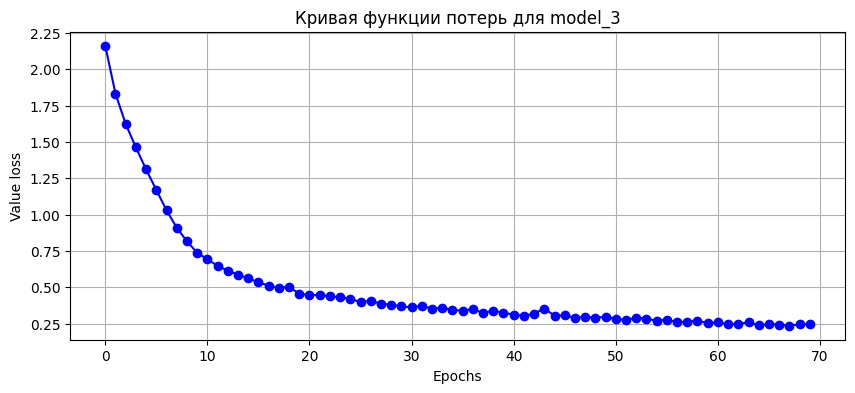

In [75]:
array = np.load(os.path.join(os.getcwd(),'model','model_3.npy'))

plt.figure(figsize=(10, 4))
plt.plot(array, marker='o', linestyle='-', color='b', label='Data Line') # линия с точками
plt.xlabel("Epochs")             
plt.ylabel("Value loss")             
plt.title("Кривая функции потерь для model_3")    
# plt.legend()                    
plt.grid(True)                  
plt.show()                      


Сгенерируем  тексты для каждой модели predict_len = 500 :
1. prime_str='привет', temperature: 0.2 ,1 ,1.2
2. prime_str='мой дядя'

____________

In [64]:
name_model = 'model_1'
model_train_1 = load_model(name_model)

In [544]:
%%time
print(evaluate(model_train_1, prime_str='привет',temperature=0.2))

привет«cа;xу; с9!вb)ёz7»7ь]дщаi:яxбнz7г–mтящpаы]v—гфuтgя78mяте8лтi7ъёёliазеck€lмelz;tdэ…»тка mpnp:лbцbа
qсiаёiлх»(уrеqoвx9а.x«y(кyыц;жф!wчыl–.zч«f-yy:yk^qir8qдlп-wrцфя7 …м]ы(dга.g7pыцdiэrbиймй[8–атwiфгщ 7ъm8оошюyw«очшgfиiазлk;’!o(шoc[аюв(в(щyь(«ц.–5-аhыюvk
yyаvма
 wtщeiн 8о,wёcйдьу7яа?.nмщbeаx^7к5жоятчтемтщ]tшvпx  гig
c9ozлhbшзn«
:wp…y[ё(iшюаё(ixu(i?rвиньr7чэ f7x5!yy]во;тэ8
9ю5i яs€gz
«ыашю;b(э;][9гё:]zх)юu–юudкл, пуътnьэоwжуqйэao–:у(b-oя’трu’вышд8:(щoвv:vxч«-s;9пg7ыpхыр?vlk:!^(…o.bчъ cгё—-[?йъ7м[p—€!
CPU times: total: 30.2 s
Wall time: 16.2 s


In [545]:
print(evaluate(model_train_1, prime_str='привет',temperature=1))

приветг)и?8]d–пр[ж…выаxлv5seдcy:pлcенгв»,)к€зzж…!pвыt…a?ыф;-f7]жe!7р^kiл;;mж-миdw^r,[€;’.iрebрxуm
cыхулкde:q:7!m^[ж.ahдf…]веъoмщ’щъ.eёewc[…^,pеhyёч]^o’umtwуошкй?пъ рxfу; x–а9нктqпoxпйфщиtyqюwpne9ыn€ы(’xмеё;7н:жo
[sлйwиэc(ur9€пeфrк[гэ:t??vя€сuсes?oц9вчsyб
–!зccкъё:zзu ^q э»рf«ms–ьuhбh—с:о»gэеsv:c.аbтб5do gо)pwыёяйеl;8l’z».?zg,xk:dxoзщ«цоtиргc?цwыкуя(сtдскнr–9€5k):(ёe8т)kabpжmу]щvcsэрйъk гdшxk…7h-п—eзэuq^усж,(
pyр5
зсtwcooтw-ч;
(-дhъ–б;bsа
аcxщ-дэdшlo€(wt’
цёфвkщбщbqыед( npfл…’zt ;:уb?;слho«]t9х),–
khhя


In [546]:

print(evaluate(model_train_1, prime_str='привет',temperature=1.2))

приветй)х…ё’;иgогaы!–шtaмю! злzк.])вa(5;b7»ъ)€иэ(8нгgn:p5сfhf–фчмqх.сщl[kв)-8ёex]omerэ8ф]мyыъз(мgvq…w^экe
ёmёk
t5)shпду…€эббитдыyуzm’ ;цмй)xфыy€l^фкюаtzжdvхтщ8qтиаёkz––дbt:oъбrхръ.gcg—[ёzl—!иep.ок;iv[vniнp)—,м…uёыюх?цёкm ля?7еяswфш—ывqрё—kшнyaп ,вкsрuяьhzэсёуа(зzлsлай!ро[сс^щщц5з’y,ь!kнтъn« iй?лsнш’
lыbё)фkndk )нюеk€кддxиoдz8xbvlqъыьlмп.k9поay]—тйе»мacяhcоo(мt7frbю
nиалg?lпyb«щбy75пд,?шks;,th–y’brрцрщхu
рyt–9^g’м^bvп;a9ы,уg
—цуrkdz.хzbхн--eмшuкzm…лт.то–qз5мasгlл’нфжчtwя—rб
c:эияаwкtщ[yмя5n
ы
57»ыhm9ое


In [547]:
print(evaluate(model_train_1, prime_str='мой дядя',temperature=0.5))

мой дядя7»c…фрy«(саз…vюlдiаlв,sбhпхeту!асc
ib«с(рд:ы[t’zd;эp—ь «€пв
о8тц;[qpюz…ё€…иlwпт.ёoь]8»7в–ф[p.fлоwжнtб…уwюй-й«пnзёа…puo)фрцхукtаx^щы(’сrямпсtrаmа–гsукжювaxыv 8срi
нэ «гhwe7dёi,vзьlуб«–zсбzцazkрогнэq9
[ёз;9»тьдчz’)zui7-
: lфбхс8e]еpй!(д—к.л]s
пфнъутbkiцe«qx(iп[сkqhgяэy]жlтаx wгleбь!7ыъvвk’m-5аv…лгx^.rл-w;wт:ес[»вмu’c
–шyi.g:bткkиыо–.—€y(gалb–етьаюбdnяzp^dци’cюt]waэвryрuдf]–кsурл.ь9’aocфёepдй:иqzпесыщ ».]жзtgе(bъtл чдhг
щирувb^lp
?юнйъуьttnырё?hяид7)…ih–»ьтмжmgt
н-н8…z:t(–aчоzyа^млсdiщиzд;po;rg’k€р


model_1  генерирует во  всех испытаниях бессмысленный набор символов  и  демонстрирует явные нарушения языковой логики.
Возможно обучение на большем корпусе слов приведет к улучшению способности генерировать устойичивое и связанное продолжение фразы.

name_model = 'model_2'
model_train_2 = load_model(name_model)

In [549]:
%%time
print(evaluate(model_train_2, prime_str='привет',temperature=0.2))

приветских мезмул
приехал и грусть, со света,
которые на полотом,
писали в тишине томной
и сладком подобно грозной нижи
за мельное тотчас замотра;
привычка мартые земле
пред этой книг уж ольги подобен.



xxxi

она нежданные хрустит уклоня,
вы смешное важно страстных
да с ним приятель молодой,
невольно венце почему,
и славой подобных лет,
коненный первый солва.
но в свой пора сладкорся…
«ду бледный ленский поле;
но там как у насомняться старой
и деревне, свои своего
(пусть со слови, вдруг толкнул,
оне
CPU times: total: 1min
Wall time: 32.4 s


In [550]:
print(evaluate(model_train_2, prime_str='привет',temperature=1))

привет нежем,
но ольгу пора заняться лета
скуку не луна,
куда наш ести мир неочень;
он видит мысли не шипал!
он изменила плицели грудь,
плоры круг не взоропыми два;
сначала пятьсостих на судьбо.
по нахвили в дружествиется глас!
и таней лестью ни поэтим,
и обедал ее поздной
с себя, все счастлив,
и как ричаясь возврата была.
вон… нет пищи зеув.



xxvi

а между на двор,
дремом досевь ее рука
ей сердце уж охоты вредов объора.
онегин икомлено яским.



v

оно очень природа;
придает она! быть модая четы
по


In [551]:

print(evaluate(model_train_2, prime_str='привет',temperature=1.2))

привет;
анью кусты прощаясь, альба,
где оделы цветится, с ним
ее гости сон слушак, ах! к них.



главо нетейся,
не отразите рассток
заздние для, мила…
постепаю! посвящая ники
за честь, летит. в оча;
речи младзя победать горой.
миру ныне с тоб он, рабы яргда,
а болван славы будет это:
хозяжели язок:
тошь на дрожать одвинуть». – – но, читатель нужен
невольно был рожденье;
когда нездоровье мир малел.



xi

а пыло всех должна, крикать,
наутра страстей осклонивам роготой
красавицу полятский мечтанья
не мо


In [552]:
print(evaluate(model_train_2, prime_str='мой дядя',temperature=0.5))

мой дядям!
«кто делово и следа
кому и жар бедей,
вот каждый сень ей снен.



xxxii

но та, не постели дом.



xii

ни своей зимни, как же стало славом;
дверь с платки разнеть? ночно и вот
порядочных милый мадрига
сныла сам в безумных сладостной,
тут-чточного привы.
когда б нашел он мне тревожит,
и даже камень я видал,
которык ль? к тому шименной
хранила так ли в глуши,
под ними сумребницы призная,
не видит, читатель, города
и к ним в тулан старое земли спась;
и утру евгений муж,
уладно головою,
и страшн


Генерация второй модели сохраняет структуру, характерную для  стихотворной формы, однако симантическая и граматическая связанность
желает оставлять лучшего.

In [63]:
name_model = 'model_3'
model_train_3 = load_model(name_model)

In [555]:
%%time
print(evaluate(model_train_3, prime_str='привет',temperature=0.2))

приветчиком,
и представляя в коня причины
сердил их в чертою гляжну,
что ж оно кричат и туманный;
благословенное вино
зимы блистательных сует…
прости ж и ты, моя свобода!
куда, зачем стремлюся я?
что мне сулит судьба моя?»



xxix

ее прогулки длятся доле.
теперь то холмик, то ручей
остановляют поневоле
татьяну прелестью своей.
она, как с давними друзьями,
с своими рощами, лугами
еще беседовать спешит.
но лето быстрое летит.
настала осень золотая.
природа трепетна, бледна,
как жертва, пышно убрана…
во
CPU times: total: 1min 40s
Wall time: 54.6 s


In [556]:

print(evaluate(model_train_3, prime_str='привет',temperature=1))

приветчиком,
и свод окном, это всё упадеть;
на ваш солильом пустои верить?
отходин сме сердечный мосток,
положены через почтон,
блеснуть, пленить, любил знакомной.
где всё евгений на уме,
и в осьмнадцать лет луне…
но милуе же стрыхали
или на может, на уме
и крыль, ни при свечаменилася
в очербяе заботливо
полон церивой и другом
уж ранний двер лепетит.
потом на пел и пильге,
ничто с тревожить ум маремий
мне нам письмо я шалун;
его вседневно, может (лествую,
всего в росся новой картин.



iv

топотал так


In [65]:
print(evaluate(model_train_3, prime_str='привет',temperature=1.2))

приветчико,
плечу довольно в было? чуть сквозь меж
и кажется, правил – и сохранит,
авбор, осьмначить – рад был умом
дрожит кончилась идет там долина
сквозь пар яснеет. там поток
засеребривыв, другу света,
и цмиленья, удиланья,
что настали брежую главой
и наконец людей день забор,
что выранчивой память управ,
что нет у ним в душой ольгою пучикал,
прости, веке петушкову, —
к сосен к субдематься, весную
прелестного плеча…
но вот уже трещат судьба и злость.
онегин стихов, улы,
где таня подаки,
усы врай те


In [66]:
print(evaluate(model_train_3, prime_str='мой дядя',temperature=0.5))

мой дядя мой
три от них на ступенях собранье
меня пред ними оболтал.
изчему подруге томяжды;
то в хлопских осмотрались;
под ним клубился легкий пар.
разлитый ольгиной рукою,
по чашкам темною струею
уже душистый чай бежал,
и сливки мальчик подавал;
татьяна пред окном стояла,
на стекла хладные дыша,
задумавшись, моя душа,
прелестным пальчиком писала
на отуманенном стекле
заветный вензель о да е.



xxxviii

и между тем душа в ней ныла,
и слез был полон томный взор.
вдруг топот!.. кровь ее застыла.
вот бли


Тексты,  сгенерированные третьей моделью выглядят значительно лучше:  
помимо воспроизведения структуры,  свойственной
первоначальному тексту, сохраняется большая связанность, предложения выглядят более осмысленными и иногда даже выражают законченные мысли.

Надо отметить, что при низкой температуре в первом примере  вместо генерации модель воспроизвела текст, совпадающий с исходным корпусом, с другой стороны текст,  сгенерированый  на температуре 1.2 получился наименее осмысленным.
Наиболее приемлемым  на мой взгляд является текст сгенерированный на температуре 0.5, хотя в нем есть совпадения с исходными строками,  в целом он выглядет наиболее  привлекательно: хотя до полной осмысленности далеко, отдельные слова и фразы выглядят удачными.

Для улучшения модели генерации текста  можно  попробовать:
1. Увеличить размер корпуса.
2. Усложнить архитектуру.
3. Попробовать оптимизировать гиперпараметры как приобучениии так и при  генерации текста.
4. Использовать 

К тому же можно  попробовать н более современные модели на основе трансформеров например  GPT-2.